In [ ]:
# # Reinstall compatible versions for PyTorch and Gym-style environments

# # 1. Force reinstall numpy 1.26.4 to avoid incompatibility with some packages
# %pip install numpy==1.26.4 --force-reinstall

# # 2. Reinstall PyTorch without pulling in numpy 2.x
# %pip install torch --force-reinstall --no-deps

# # 3. Install other necessary libraries (gym-style envs, plotting, etc.)
# %pip install gymnasium nest_asyncio matplotlib

# # 4. Install sympy and dependencies
# %pip install sympy mpmath

# # 5. (Recommended) Install missing torch dependencies
# %pip install filelock fsspec jinja2 networkx

# # Optional: Update pip to latest version
# # %pip install --upgrade pip

  Obtaining dependency information for numpy==1.26.4 from https://files.pythonhosted.org/packages/11/57/baae43d14fe163fa0e4c47f307b6b2511ab8d7d30177c491960504252053/numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/3f/14/e105b8ef6d324e789c1589e95cb0ab63f3e07c2216d68b1178b7c21b7d2a/torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata
  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
Using c

In [2]:
import numpy as np
import torch
# import gym
import asyncio

print("NumPy:", np.__version__)
print("PyTorch:", torch.__version__)

from gymnasium.spaces import Box, Space
from gymnasium.utils.env_checker import check_env

import air_land_sea_env
print(air_land_sea_env.__file__)

from air_land_sea_env import AirLandSeaBaseEnv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from os import truncate
from collections import namedtuple, deque
from itertools import count

import random
import math

from torch.distributions import Categorical

#set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NumPy: 1.26.4
PyTorch: 2.2.2
/Users/alexkang/PycharmProjects/AirLandSea/air_land_sea_env.py


In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations=69, n_actions=37): # n_observations and n_actions will be dynamic
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128) #
        self.layer2 = nn.Linear(128, 128) #
        self.layer3 = nn.Linear(128, n_actions) #

    def forward(self, x):
        x = F.relu(self.layer1(x)) #
        x = F.relu(self.layer2(x)) #
        return self.layer3(x) #
    
# class DQN(nn.Module):
#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()

#         # Define the linear layers
#         self.layer1 = nn.Linear(n_observations, 256)
#         self.layer2 = nn.Linear(256, 256)
#         self.layer3 = nn.Linear(256, 128)
#         self.layer4 = nn.Linear(128, n_actions)

#     def forward(self, x):
#         # Define the forward pass
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
#         x = self.layer4(x)
#         return x

In [4]:
# Do not modify
class Transition(object):
  def __init__(self, s, a, next_s, r):
    self.state = s
    self.action = a
    self.next_state = next_s
    self.reward = r


class ExperienceReplay(object):
    def __init__(self, capacity):

        # Capacity of the agent's memory, always an int
        self.cap = capacity
        # A list of Transition objects that represent the agent's experiences
        self.memory = []
        # Current position of the agent, 0 <= self.pos < len(self.memory)
        self.pos = 0


    def push(self, *args):
        """
        Push a transition to the agent's memory.
        """
        if len(self.memory) < self.cap:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.cap


    def sample(self, batch_size):
        """
        Uniformly random sample batch_size of Transitions
        """
        return random.sample(self.memory, batch_size)


    def __len__(self):
        return len(self.memory)

In [5]:
import random

class DQNAgent:
    def __init__(self, env, memory_capacity=10000, batch_size=128, gamma=0.95,
                 epsilon_start=0.9, epsilon_end=0.08, epsilon_decay=3000,
                 target_update=10, lr=1e-3):
        
        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay = epsilon_decay
        self.target_update = target_update
        self.lr = lr

        state, _ = env.reset()
        self.n_actions = env.action_space.n
        self.n_observations = len(state)
        self.steps_done = 0

        self.policy_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.memory = ExperienceReplay(memory_capacity)

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr)
        self.criterion = nn.SmoothL1Loss()


    def select_action(self, state, env):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        action_mask = env._get_action_mask()
        legal_actions = np.where(action_mask)[0] #

        if len(legal_actions) == 0:
            # This should ideally not happen if the environment always provides valid moves
            # (e.g., withdraw is always possible in NORMAL_PLAY phase).
            # If it does, it might indicate an issue with the env state or mask generation.
            # For robustness, one might choose a random action from all n_actions or raise an error.
            # Given AirLandSeaBaseEnv's action_space.sample() has a fallback,
            # we could pick a random available action, but it's better if mask is always valid.
            # For now, we assume 'legal_actions' will not be empty if called appropriately.
            print("Warning: No legal actions found in select_action based on mask. Defaulting if possible.")
            # Fallback to a random choice from all actions if legal_actions is empty.
            # This should be an exceptional case.
            if self.n_actions > 0:
                 return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
            else:
                 raise ValueError("No legal actions and n_actions is 0.")

        if sample > eps_threshold:
            with torch.no_grad():
                # If state is already a tensor and has a batch dimension, use it directly.
                if isinstance(state, torch.Tensor):
                    # If the state does not have a batch dimension, add one.
                    state_tensor = state if state.dim() == 2 else state.unsqueeze(0)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    
                q_values = self.policy_net(state_tensor)
                
                # Apply the mask: set Q-values of illegal actions to -infinity
                masked_q_values = q_values.clone() #
                for action_idx in range(self.n_actions): #
                    if action_idx not in legal_actions: #
                        masked_q_values[0, action_idx] = -float('inf') #
                        
                action_index = masked_q_values.argmax().item()
                return torch.tensor([[action_index]], device=device, dtype=torch.long)
        else:
            rand_action = random.choice(legal_actions)
            return torch.tensor([[rand_action]], device=device, dtype=torch.long)


    def get_values(self):
        """
        Returns the states, actions, and rewards from the sampled batch of transitions in memory.

        The function performs the following steps:
        1. Checks if the number of transitions in memory is less than the batch size. If so, it exits early.
        2. Samples a batch of transitions from memory.
        3. Extracts states, next states, actions, and rewards from the sampled transitions.
        4. Creates a mask to identify non-final next states (states that are not None).
        5. Collates all non-final next states, states, actions, and rewards into their respective batches.

        Returns:
            tuple: A tuple containing the following elements:
            - Q-values of the current states based on the policy network (Tensor).
            - Batch of rewards (Tensor).
            - Mask identifying non-final next states (Boolean Tensor).
            - Batch of non-final next states (Tensor).
        """
        if len(self.memory) < self.batch_size:
            return None
        batch = self.memory.sample(self.batch_size)

        next_state = []
        state = []
        action = []
        reward = []
        for x in batch:
          next_state.append(x.next_state)
          state.append(x.state)
          action.append(x.action)
          reward.append(x.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in next_state if s is not None])

        state_batch = torch.cat(state)
        action_batch = torch.cat(action)
        reward_batch = torch.cat(reward)

        return self.policy_net(state_batch).gather(1, action_batch), reward_batch, non_final_mask, non_final_next_states


    def optimize_model(self):
        if self.get_values() is not None:
            state_action_values, reward_batch, non_final_mask, non_final_next_states = self.get_values()
        else:
            return

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        # with torch.no_grad():
        #     # Use policy_net to select the action with the highest Q-value
        #     next_actions = self.policy_net(non_final_next_states).argmax(1).unsqueeze(1)
        #     # Use target_net to evaluate the Q-value of the selected action
        #     next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, next_actions).squeeze()

        expected_state_action_values = reward_batch + self.gamma * next_state_values
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1)
        self.optimizer.step()


In [6]:
import numpy as np
import torch
from collections import deque
from itertools import count
import math

# Make sure your DQNAgent, DQN model, ExperienceReplay, Transition,
# AirLandSeaBaseEnv, opponent policy classes (e.g., RandomOpponentPolicy),
# and 'device' are defined or imported correctly above this function.

def train_dqn(agent: 'DQNAgent', env: 'AirLandSeaBaseEnv', opponent: 'BaseOpponentPolicy',
              num_episodes=5000, save_path="air_land_sea_dqn_agent_weights.pth"):
    episode_durations = []
    episode_total_rewards_agent = [] # Tracks rewards for the learning agent
    win_rates_log = []
    recent_wins_agent = deque(maxlen=100) # Tracks wins for the learning agent

    LEARNING_AGENT_PLAYER_IDX = 0 # Agent is Player 0
    # Opponent's player index is known from opponent.player_idx

    print(f"Training Agent P{LEARNING_AGENT_PLAYER_IDX} against opponent P{opponent.player_idx} ({type(opponent).__name__})")

    for i_episode in range(num_episodes):
        current_state_np, initial_info = env.reset()
        # env.reset() in AirLandSeaBaseEnv sets current_player_idx to 0 (LEARNING_AGENT_PLAYER_IDX)
        
        current_state_tensor = torch.tensor(current_state_np, dtype=torch.float32, device=device).unsqueeze(0)
        current_episode_agent_reward = 0.0
        
        # Buffer for P0's state, action, and reward, waiting for the true next_state after P1's turn
        p0_s_buffer = None
        p0_a_buffer_tensor = None
        p0_r_buffer_tensor = None
        
        latest_info = initial_info # To store the info dict from the step that ends the episode

        for t in count(): # t represents decision steps in the episode
            current_player_from_env = env.current_player_idx

            if current_player_from_env == LEARNING_AGENT_PLAYER_IDX:
                # --- Learning Agent's (P0) Turn to Decide ---
                if p0_s_buffer is not None:
                    # This should not happen if logic is correct; P0 should not have a pending S,A,R
                    # if it's P0's turn again unless it was a sub-step already handled.
                    print(f"Warning: P0 buffer was not cleared before P0's new turn. Episode {i_episode+1}, t={t}")
                    p0_s_buffer = None # Clear stale buffer

                s_for_p0_action = current_state_tensor
                
                action_tensor_p0 = agent.select_action(s_for_p0_action, env)
                action_p0 = action_tensor_p0.item()

                next_raw_state_np, reward_p0, terminated, truncated, info_after_p0_step = env.step(action_p0)
                current_episode_agent_reward += reward_p0
                reward_p0_tensor = torch.tensor([reward_p0], device=device)
                done = terminated or truncated
                latest_info = info_after_p0_step

                if done: # Game ended on P0's move
                    agent.memory.push(s_for_p0_action, action_tensor_p0, None, reward_p0_tensor)
                    current_state_tensor = None # Mark episode ended
                    break # from for t loop

                if env.current_player_idx == LEARNING_AGENT_PLAYER_IDX: # P0's move led to a sub-step for P0
                    next_p0_substep_tensor = torch.tensor(next_raw_state_np, dtype=torch.float32, device=device).unsqueeze(0)
                    agent.memory.push(s_for_p0_action, action_tensor_p0, next_p0_substep_tensor, reward_p0_tensor)
                    current_state_tensor = next_p0_substep_tensor # P0 continues with this new state
                    # p0_s_buffer remains None as this transition is fully recorded
                else: # P0's move sequence is done, turn has passed to P1 (opponent)
                    p0_s_buffer = s_for_p0_action
                    p0_a_buffer_tensor = action_tensor_p0
                    p0_r_buffer_tensor = reward_p0_tensor
                    current_state_tensor = torch.tensor(next_raw_state_np, dtype=torch.float32, device=device).unsqueeze(0) # State for P1
            
            elif current_player_from_env == opponent.player_idx:
                # --- Opponent's (P1) Turn to Decide ---
                # current_state_tensor is for P1
                current_p1_state_np = current_state_tensor.squeeze(0).cpu().numpy() # Opponent policy might want np
                
                opponent_action = opponent.select_action(current_p1_state_np, env) # Opponent uses env for mask
                next_raw_state_np, _, terminated, truncated, info_after_p1_step = env.step(opponent_action)
                # Reward for P1's action is ignored for P0's learning.
                done = terminated or truncated
                latest_info = info_after_p1_step

                if done: # Game ended on P1's move
                    if p0_s_buffer is not None: # P0 had an action pending its S'
                        agent.memory.push(p0_s_buffer, p0_a_buffer_tensor, None, p0_r_buffer_tensor)
                        p0_s_buffer = None
                    current_state_tensor = None # Episode ended
                    break # from for t loop
                
                if env.current_player_idx == opponent.player_idx: # P1's move led to a sub-step for P1
                    current_state_tensor = torch.tensor(next_raw_state_np, dtype=torch.float32, device=device).unsqueeze(0) # P1 continues
                    # P0's (s,a,r) still buffered, waiting for P1 to finish and pass turn to P0
                else: # P1's move sequence is done, turn has passed back to P0
                    if p0_s_buffer is not None: # P0 had an action pending its S'
                        next_p0_state_tensor = torch.tensor(next_raw_state_np, dtype=torch.float32, device=device).unsqueeze(0)
                        agent.memory.push(p0_s_buffer, p0_a_buffer_tensor, next_p0_state_tensor, p0_r_buffer_tensor)
                        p0_s_buffer = None # Clear buffer as transition is stored
                    current_state_tensor = torch.tensor(next_raw_state_np, dtype=torch.float32, device=device).unsqueeze(0) # State for P0's next turn
            
            else: # Should not happen
                print(f"CRITICAL Logic Error: Unexpected player index {current_player_from_env} in episode {i_episode+1}, step {t}. Breaking episode.")
                break

            agent.optimize_model()

            if done or current_state_tensor is None : # Episode is over
                break 
        # End of for t in count() loop (inner episode loop)

        episode_durations.append(t + 1)
        episode_total_rewards_agent.append(current_episode_agent_reward)

        # Log win based on the latest info from the step that ended the episode
        if latest_info.get("battle_winner_idx") == LEARNING_AGENT_PLAYER_IDX:
            recent_wins_agent.append(1)
        elif latest_info.get("battle_winner_idx") is not None: # Opponent won or draw
            recent_wins_agent.append(0)

        if (i_episode + 1) % 20 == 0: # Print stats every 20 episodes
            # Calculate averages safely, ensuring lists are not empty
            avg_duration = np.mean(episode_durations[-20:]) if len(episode_durations) >= 20 else (np.mean(episode_durations) if episode_durations else 0)
            avg_reward_agent = np.mean(episode_total_rewards_agent[-20:]) if len(episode_total_rewards_agent) >= 20 else (np.mean(episode_total_rewards_agent) if episode_total_rewards_agent else 0)
            current_win_rate_agent = sum(recent_wins_agent) / len(recent_wins_agent) if len(recent_wins_agent) > 0 else 0.0
            print(f"Episode {i_episode+1}/{num_episodes} | Agt P{LEARNING_AGENT_PLAYER_IDX} Avg Reward (last up to 20): {avg_reward_agent:.2f} | Win Rate (last {len(recent_wins_agent)}): {current_win_rate_agent:.2%}")

        if (i_episode + 1) % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
            if len(recent_wins_agent) > 0: 
                win_rates_log.append(sum(recent_wins_agent) / len(recent_wins_agent))
    
    print('Training complete')
    env.close()
    if save_path:
        torch.save(agent.policy_net.state_dict(), save_path)
        print(f"Agent P{LEARNING_AGENT_PLAYER_IDX} model weights saved to {save_path}")
        
    return episode_durations, episode_total_rewards_agent, win_rates_log

In [ ]:
def train_from_scratch(
        opponent_policy_instance: 'BaseOpponentPolicy',
        output_weights_path: str,
        num_episodes: int = 12000, # Defaulting to your new request
        agent_hyperparams: dict = None
        ):
    """
    Sets up and runs a training session for the AirLandSeaBaseEnv.

    Args:
        opponent_policy_instance: An instantiated opponent policy object.
        output_weights_path: Path to save the trained agent's weights.
        num_episodes: Number of episodes to train for.
        agent_hyperparams: A dictionary of hyperparameters for the DQNAgent.
                           Overrides defaults if provided.
    Returns:
        A tuple of (durations, total_rewards, logged_win_rates) from train_dqn.
    """
    # Initialize environment
    env = AirLandSeaBaseEnv() #
    print(f"Environment: AirLandSeaBaseEnv") #
    print(f"Observation space shape: {env.observation_space.shape}") #
    print(f"Action space size: {env.action_space.n}") #

    # Default agent hyperparameters
    default_hyperparams = {
        'memory_capacity': 20000, #
        'batch_size': 256, #
        'gamma': 0.99, #
        'epsilon_start': 1.0, #
        'epsilon_end': 0.01, #
        'epsilon_decay': 20000, #
        'target_update': 100, #
        'lr': 5e-5 #
    }
    
    current_agent_hyperparams = default_hyperparams.copy()
    if agent_hyperparams:
        current_agent_hyperparams.update(agent_hyperparams)

    # Create the learning agent (Player 0)
    # The DQNAgent __init__ takes env as the first argument
    learning_agent = DQNAgent(env, **current_agent_hyperparams) #

    print(f"Starting training for {num_episodes} episodes...") #
    print(f"Learning Agent (P0) Hyperparameters: {current_agent_hyperparams}")
    print(f"Opponent Policy: {type(opponent_policy_instance).__name__} for P{opponent_policy_instance.player_idx}")


    # Call the existing train_dqn function
    # The train_dqn function should handle saving the model to output_weights_path
    training_logs = train_dqn(
        agent=learning_agent,
        env=env,
        opponent=opponent_policy_instance,
        num_episodes=num_episodes,
        save_path=output_weights_path # Pass the path here for train_dqn to use
    ) 

    print(f"Training session complete. Model for P0 potentially saved to {output_weights_path}")
    return training_logs

In [ ]:

from opponent_policies import RandomOpponentPolicy 

# Set device (should be defined globally, e.g., at the start of your script/notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opponent_for_training = RandomOpponentPolicy(opponent_player_idx=1) #
model_output_path = "random_small_dqn.pth"

# Define any custom hyperparameters for the agent for this session
custom_hyperparams = {
    'epsilon_decay': 60000, # Example: different epsilon_decay
    'lr': 1e-4
}

# Run the training session
# Using your requested 12000 episodes
durations, total_rewards, logged_win_rates = run_training_session(
    opponent_policy_instance=opponent_for_training,
    output_weights_path=model_output_path,
    num_episodes=12000, # Changed as per your request
    agent_hyperparams=custom_hyperparams 
)


In [7]:
from opponent_policies import RandomOpponentPolicy

env = AirLandSeaBaseEnv()
print(f"Environment: AirLandSeaBaseEnv")
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Action space size: {env.action_space.n}")

# Create the learning agent (Player 0)
learning_agent = DQNAgent(
    env, 
    memory_capacity=20000, 
    batch_size=256, 
    gamma=0.99,
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay=50000, 
    target_update=100, 
    lr=5e-5)

# Choose an opponent policy

opponent = RandomOpponentPolicy(opponent_player_idx=1)

# opponent = HeuristicOpponentPolicy(opponent_player_idx=1) # if you implement one

# To use a DQNOpponentPolicy:
# opponent_dqn_path = "path_to_opponent_weights.pth"
# opponent = DQNOpponentPolicy(opponent_player_idx=1, model_path=opponent_dqn_path,
#                              n_observations=env.observation_space.shape[0],
#                              n_actions=env.action_space.n)


num_train_episodes = 20000 # Adjust as needed
print(f"Starting training for {num_train_episodes} episodes...")

durations, total_rewards, logged_win_rates = train_dqn(
    agent=learning_agent, 
    env=env, 
    opponent=opponent, # Pass the chosen opponent
    num_episodes=num_train_episodes, 
    save_path="p0_vs_random_als_dqn.pth" # Example save path
)

Environment: AirLandSeaBaseEnv
Observation space shape: (69,)
Action space size: 37
Starting training for 20000 episodes...
Training Agent P0 against opponent P1 (RandomOpponentPolicy)
Episode 20/20000 | Agt P0 Avg Reward (last up to 20): -2.20 | Win Rate (last 20): 45.00%
Episode 40/20000 | Agt P0 Avg Reward (last up to 20): -1.35 | Win Rate (last 40): 52.50%
Episode 60/20000 | Agt P0 Avg Reward (last up to 20): -0.85 | Win Rate (last 60): 55.00%
Episode 80/20000 | Agt P0 Avg Reward (last up to 20): -0.50 | Win Rate (last 80): 55.00%
Episode 100/20000 | Agt P0 Avg Reward (last up to 20): -1.40 | Win Rate (last 99): 53.54%
Episode 120/20000 | Agt P0 Avg Reward (last up to 20): -1.80 | Win Rate (last 100): 55.00%
Episode 140/20000 | Agt P0 Avg Reward (last up to 20): -1.15 | Win Rate (last 100): 54.00%
Episode 160/20000 | Agt P0 Avg Reward (last up to 20): -1.35 | Win Rate (last 100): 53.00%
Episode 180/20000 | Agt P0 Avg Reward (last up to 20): -1.85 | Win Rate (last 100): 51.00%
Episo

NameError: name 'agent' is not defined

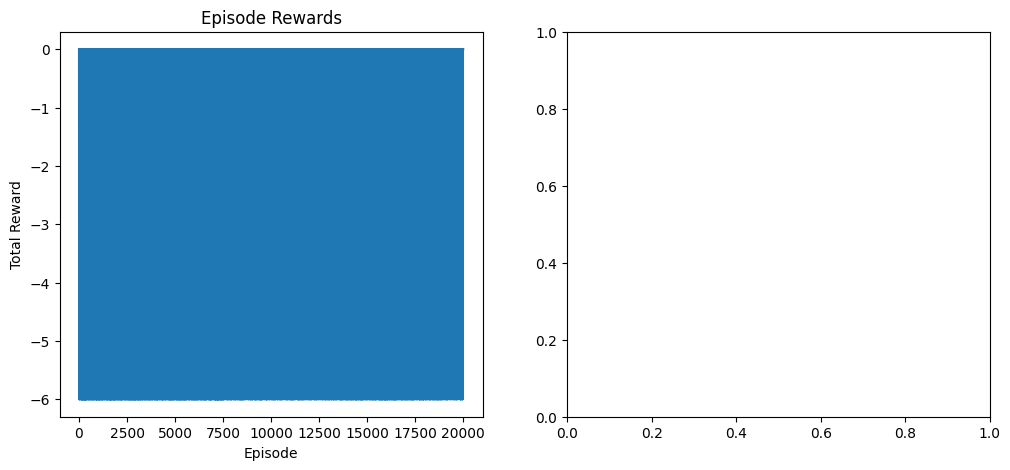

In [8]:
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    if logged_win_rates:
        plt.subplot(1, 2, 2)
        # Create an x-axis based on when win rates were logged (e.g., every target_update episodes)
        # This assumes win_rates_log is appended every agent.target_update episodes.
        # If logged differently, adjust x_axis accordingly.
        log_interval = agent.target_update 
        x_axis_win_rates = [i * log_interval for i in range(len(logged_win_rates))]
        plt.plot(x_axis_win_rates, logged_win_rates)
        plt.title('Rolling Win Rate (at Target Updates)')
        plt.xlabel(f'Episode (multiples of {log_interval})')
        plt.ylabel('Win Rate')
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not installed. Skipping plots.")